In [ ]:
import os
import sys
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import seaborn as sns
import torch.nn.init as init
import torch.nn.utils.prune as prune
import pandas as pd

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
traindataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
testdataset = datasets.MNIST('../data', train=False, transform=transform)

In [ ]:
val_size = 5000
train_size = 55000

traindataset, valdataset = torch.utils.data.random_split(traindataset, [train_size, val_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(traindataset, batch_size=60, shuffle=True, num_workers=0, drop_last=False)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=100, shuffle=False, num_workers=0, drop_last=True)
val_loader = torch.utils.data.DataLoader(valdataset, batch_size=100, shuffle=False, num_workers=0, drop_last=True)

In [ ]:
class LeNet300100(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet300100, self).__init__()
    
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, num_classes)

        self.init_weights_()
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

    def init_weights_(self):
        for m in self.parameters():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight.data)
                init.normal_(m.bias.data)

In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy, test_loss

In [ ]:
def print_sparsity(model):
    fc1_sparsity = 100. * float(torch.sum(model.fc1.weight == 0)) / float(model.fc1.weight.nelement())
    fc2_sparsity = 100. * float(torch.sum(model.fc2.weight == 0)) / float(model.fc2.weight.nelement())
    fc3_sparsity = 100. * float(torch.sum(model.fc3.weight == 0)) / float(model.fc3.weight.nelement())

    print(
    "Sparsity in fc1.weight: {:.2f}%".format(
            fc1_sparsity
        )
    )
    print(
    "Sparsity in fc2.weight: {:.2f}%".format(
            fc2_sparsity
        )
    )
    print(
    "Sparsity in fc3.weight: {:.2f}%".format(
            fc3_sparsity
        )
    )
    avg_sparsity = float(torch.sum(model.fc1.weight == 0) + torch.sum(model.fc2.weight == 0) + torch.sum(model.fc3.weight == 0)) / float(model.fc1.weight.nelement() + model.fc2.weight.nelement() + model.fc3.weight.nelement())
    print(
    "Avg model Sparsity: {:.2f}%".format(
            avg_sparsity
        )
    )
    return avg_sparsity

In [ ]:
from copy import deepcopy

model = LeNet300100().to(device)
theta0 = deepcopy(model.state_dict())
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.0012)
criterion = nn.CrossEntropyLoss() 

In [ ]:
theta0['fc1.weight']

tensor([[-0.0130,  0.0279,  0.0192,  ..., -0.0277,  0.0276, -0.0142],
        [-0.0284, -0.0250, -0.0216,  ..., -0.0114, -0.0100,  0.0148],
        [ 0.0202,  0.0315, -0.0310,  ..., -0.0042, -0.0252,  0.0134],
        ...,
        [ 0.0105, -0.0238,  0.0356,  ..., -0.0063,  0.0305,  0.0179],
        [ 0.0189,  0.0253, -0.0158,  ...,  0.0162, -0.0128, -0.0313],
        [ 0.0256,  0.0051,  0.0208,  ..., -0.0111,  0.0293, -0.0026]],
       device='cuda:0')

In [ ]:
from IPython.display import clear_output
from collections import defaultdict

# так делался эксперимент для обычного iterative lottery ticket 
num_epochs = 20
eval_every = 100
prune_its = 20
p = 20 / 100
print(f'p = {p * 100}%')
results = []

for it in range(prune_its): # количество итераций прунинга
    print(f'[Prune:{it}/{prune_its}]')
    avg_sparsity = print_sparsity(model)
    step = 0
    test_accs_it = []
    val_losses_it = []
    val_accs_it = []
    for epoch in range(num_epochs): # количество эпох обучения модели (типа до сходимости)
        epoch_loss = 0.0
        for batch_idx, (imgs, targets) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            imgs, targets = imgs.to(device), targets.to(device)
            output = model(imgs)
            train_loss = criterion(output, targets)
            train_loss.backward()
            epoch_loss += train_loss.item()
            optimizer.step()
    
            step += 1
            if step % eval_every == 0:
                test_acc_step, test_loss_step = test(model, test_loader, criterion)
                val_acc_step, val_loss_step = test(model, val_loader, criterion)
                test_accs_it.append(test_acc_step)
                val_losses_it.append(val_loss_step)
                val_accs_it.append(val_acc_step)

        epoch_loss /= len(train_loader)
        test_acc_epoch = test(model, test_loader, criterion)
        print(f"[Ep:{epoch + 1}/{num_epochs}] Train Loss: {epoch_loss:.{5}}    Test Acc Epoch: {test_acc_epoch[0]}")

    it_results = {
        'prune_it': it,
        'avg_sparsity': avg_sparsity,
        'test_accs': test_accs_it,
        'val_losses': val_losses_it,
        'val_accs': val_accs_it,
        
    }

    results.append(it_results)

    if it != prune_its - 1: # пруним
        with torch.no_grad():
            prune.l1_unstructured(model.fc1, name="weight", amount=p)
            prune.l1_unstructured(model.fc2, name="weight", amount=p)
            prune.l1_unstructured(model.fc3, name="weight", amount=p/2)

            model.fc1.weight_orig.data = deepcopy(theta0['fc1.weight'].data)
            model.fc1.weight.data = deepcopy(theta0['fc1.weight'].data * model.fc1.weight_mask.data)
            model.fc1.bias.data = deepcopy(theta0['fc1.bias'].data)

            model.fc2.weight_orig.data = deepcopy(theta0['fc2.weight'].data)
            model.fc2.weight.data = deepcopy(theta0['fc2.weight'].data * model.fc2.weight_mask.data)
            model.fc2.bias.data = deepcopy(theta0['fc2.bias'].data)

            model.fc3.weight_orig.data = deepcopy(theta0['fc3.weight'].data)
            model.fc3.weight.data = deepcopy(theta0['fc3.weight'].data * model.fc3.weight_mask.data)
            model.fc3.bias.data = deepcopy(theta0['fc3.bias'].data)

            optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.0012)

            # чтобы делать reinit (а не приравнивать к изначальным параметрам) нужно заменить на 
            # model.fc2.weight.data = deepcopy(xavier_normal_(theta0['fc2.weight'].data))

p = 20.0%
[Prune:0/20]
Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Avg model Sparsity: 0.00%
[Ep:1/10] Train Loss: 0.2266    Test Acc Epoch: 95.49
[Ep:2/10] Train Loss: 0.095928    Test Acc Epoch: 96.96
[Ep:3/10] Train Loss: 0.068616    Test Acc Epoch: 97.48
[Ep:4/10] Train Loss: 0.056615    Test Acc Epoch: 97.37
[Ep:5/10] Train Loss: 0.047178    Test Acc Epoch: 97.47
[Ep:6/10] Train Loss: 0.04161    Test Acc Epoch: 97.81
[Ep:7/10] Train Loss: 0.036664    Test Acc Epoch: 97.9
[Ep:8/10] Train Loss: 0.034638    Test Acc Epoch: 97.42
[Ep:9/10] Train Loss: 0.029136    Test Acc Epoch: 97.86
[Ep:10/10] Train Loss: 0.029007    Test Acc Epoch: 97.88
[Prune:1/20]
Sparsity in fc1.weight: 20.00%
Sparsity in fc2.weight: 20.00%
Sparsity in fc3.weight: 10.00%
Avg model Sparsity: 0.20%
[Ep:1/10] Train Loss: 0.22581    Test Acc Epoch: 96.17
[Ep:2/10] Train Loss: 0.091877    Test Acc Epoch: 96.75
[Ep:3/10] Train Loss: 0.065764    Test Acc Epoch: 96.92
[Ep:4

In [ ]:
import json

with open('iterative_lottery_exp_20percent_10ep_20prit.json', 'w') as fp:
    json.dump(results, fp)

In [ ]:
labels = [int(100*results[0]['avg_sparsity']) for i in range(len(results))]

### Смотрим на accuracy на тесте в зависимости от итерации обучения для разных разреженностей моделей

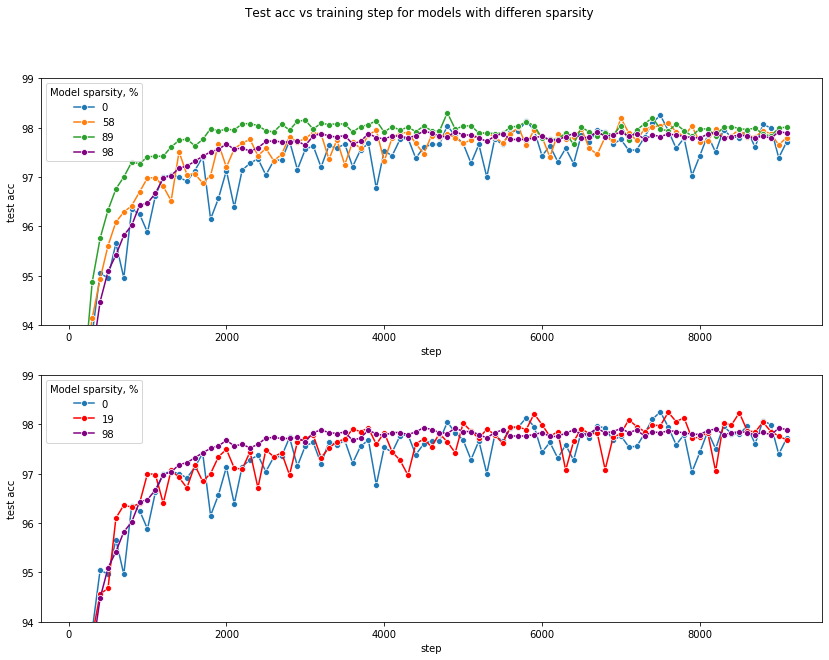

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

steps = (np.arange(len(results[0]['test_accs']) ) + 1) * 100
l0 = sns.lineplot(x=steps, y=results[0]['test_accs'], marker='o', label=labels[0], ax=axes[0])
l1 = sns.lineplot(x=steps, y=results[4]['test_accs'], marker='o', label=labels[4],ax=axes[0])
l2 = sns.lineplot(x=steps, y=results[10]['test_accs'], marker='o', label=labels[10],ax=axes[0])
sns.lineplot(x=steps, y=results[19]['test_accs'], marker='o', label=int(100*results[19]['avg_sparsity']), color='purple', ax=axes[0])
axes[0].legend(title='Model sparsity, %')
axes[0].set_ylim((94, 99))
axes[0].set_ylabel('test acc')
axes[0].set_xlabel('step')

l3 = sns.lineplot(x=steps, y=results[0]['test_accs'], marker='o', label=labels[0], ax=axes[1])
l4 = sns.lineplot(x=steps, y=results[1]['test_accs'], marker='o', label=labels[1], ax=axes[1], color='red')
l5 = sns.lineplot(x=steps, y=results[19]['test_accs'], marker='o', label=labels[19], ax=axes[1], color='purple')
axes[1].legend(title='Model sparsity, %')
axes[1].set_ylabel('test acc')
axes[1].set_ylim((94, 99))
axes[1].set_xlabel('step')

plt.suptitle('Test acc vs training step for models with differen sparsity');

In [ ]:
with open('iterative_lottery_exp_20percent_10ep_10prit_reinit.json') as f:
    reinit_results = json.load(f)

### Сравнивем с реинициализацией. 

То есть после прунинга и получение маски $m$ делаем $\theta = \theta_0 \odot m$ не для той самой начальной $\theta_0$ , а  берем новое $\theta_0 \sim \mathcal{D}$

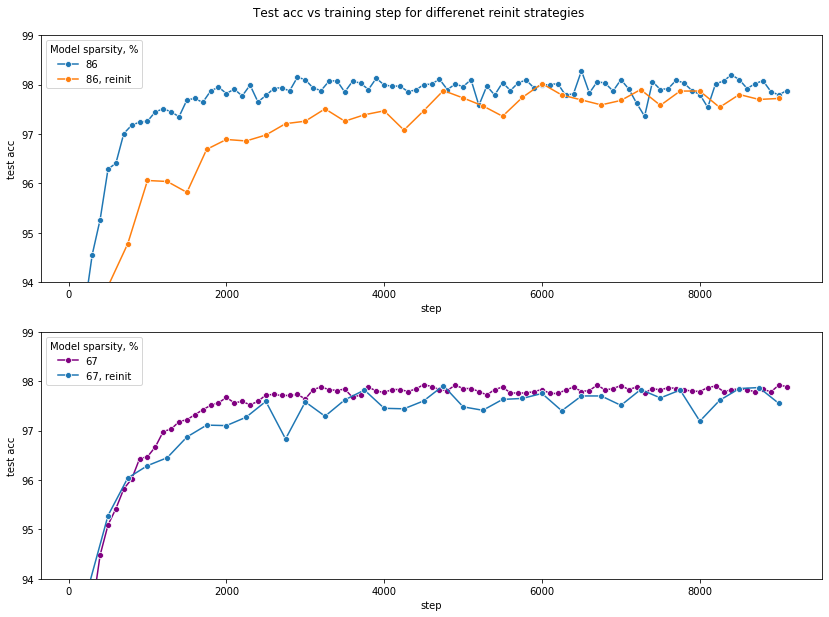

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

steps1 = (np.arange(len(results[0]['test_accs']) ) + 1) * 100
steps2 = (np.arange(len(reinit_results[0]['test_accs']) ) + 1) * 250
sns.lineplot(x=steps, y=results[9]['test_accs'], marker='o',
             label=labels[9],ax=axes[0])

sns.lineplot(x=steps2, y=reinit_results[9]['test_accs'], marker='o',
             label=f"{int(100*reinit_results[9]['avg_sparsity'])}, reinit", ax=axes[0])

axes[0].legend(title='Model sparsity, %')
axes[0].set_ylim((94, 99))
axes[0].set_ylabel('test acc')
axes[0].set_xlabel('step')

sns.lineplot(x=steps, y=results[19]['test_accs'], marker='o', label=labels[5], ax=axes[1], color='purple')
sns.lineplot(x=steps2, y=reinit_results[5]['test_accs'], marker='o',
             label=f"{int(100*reinit_results[5]['avg_sparsity'])}, reinit",ax=axes[1])

axes[1].legend(title='Model sparsity, %', loc='upper left')
axes[1].set_ylabel('test acc')
axes[1].set_ylim((94, 99))
axes[1].set_xlabel('step')

plt.suptitle('Test acc vs training step for differenet reinit strategies', y=0.92);

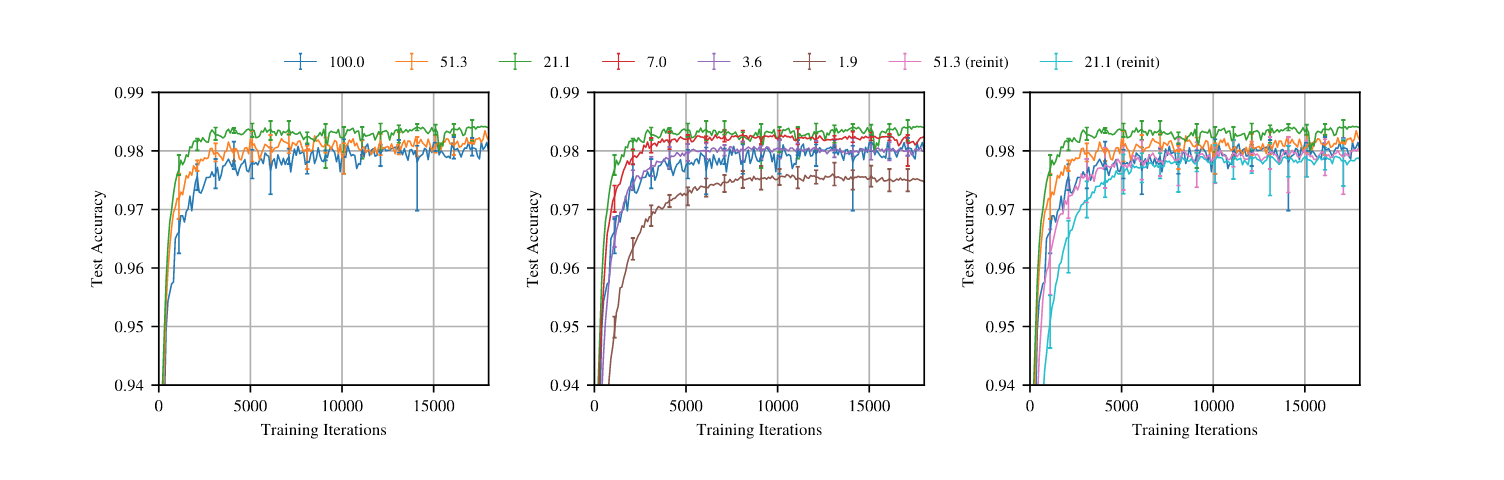

In [ ]:
# обернул код, чтобы сделать oneshot
def pruning_exp(num_epochs, prune_its, p, eval_every):
    model = LeNet300100().to(device)
    theta0 = deepcopy(model.state_dict())
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.0012)
    criterion = nn.CrossEntropyLoss() 
    print(f'p = {p * 100}%')
    results = []
    for it in range(prune_its):
        print(f'[Prune:{it}/{prune_its}]')
        avg_sparsity = print_sparsity(model)
        step = 0
        test_accs_it = []
        val_losses_it = []
        val_accs_it = []
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            for batch_idx, (imgs, targets) in enumerate(train_loader):
                model.train()
                optimizer.zero_grad()
                imgs, targets = imgs.to(device), targets.to(device)
                output = model(imgs)
                train_loss = criterion(output, targets)
                train_loss.backward()
                epoch_loss += train_loss.item()
                optimizer.step()

                step += 1
                if step % eval_every == 0:
                    test_acc_step, test_loss_step = test(model, test_loader, criterion)
                    val_acc_step, val_loss_step = test(model, val_loader, criterion)
                    test_accs_it.append(test_acc_step)
                    val_losses_it.append(val_loss_step)
                    val_accs_it.append(val_acc_step)

            epoch_loss /= len(train_loader)
            test_acc_epoch = test(model, test_loader, criterion)
            print(f"[Ep:{epoch + 1}/{num_epochs}] Train Loss: {epoch_loss:.{5}}    Test Acc Epoch: {test_acc_epoch[0]}")

        it_results = {
            'prune_it': it,
            'avg_sparsity': avg_sparsity,
            'test_accs': test_accs_it,
            'val_losses': val_losses_it,
            'val_accs': val_accs_it,

        }

        results.append(it_results)

        if it != prune_its - 1:
            with torch.no_grad():
                prune.l1_unstructured(model.fc1, name="weight", amount=p)
                prune.l1_unstructured(model.fc2, name="weight", amount=p)
                prune.l1_unstructured(model.fc3, name="weight", amount=p/2)

                model.fc1.weight_orig.data = deepcopy(theta0['fc1.weight'].data)
                model.fc1.weight.data = deepcopy(theta0['fc1.weight'].data * model.fc1.weight_mask.data)
                model.fc1.bias.data = deepcopy(theta0['fc1.bias'].data)

                model.fc2.weight_orig.data = deepcopy(theta0['fc2.weight'].data)
                model.fc2.weight.data = deepcopy(theta0['fc2.weight'].data * model.fc2.weight_mask.data)
                model.fc2.bias.data = deepcopy(theta0['fc2.bias'].data)

                model.fc3.weight_orig.data = deepcopy(theta0['fc3.weight'].data)
                model.fc3.weight.data = deepcopy(theta0['fc3.weight'].data * model.fc3.weight_mask.data)
                model.fc3.bias.data = deepcopy(theta0['fc3.bias'].data)

                optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.0012)
    return results

In [ ]:
one_shot_86 = pruning_exp(10, 2, 0.86, 100)

p = 86.0%
[Prune:0/2]
Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Avg model Sparsity: 0.00%
[Ep:1/10] Train Loss: 0.22817    Test Acc Epoch: 96.65
[Ep:2/10] Train Loss: 0.096615    Test Acc Epoch: 97.31
[Ep:3/10] Train Loss: 0.069246    Test Acc Epoch: 97.0
[Ep:4/10] Train Loss: 0.053785    Test Acc Epoch: 97.42
[Ep:5/10] Train Loss: 0.047155    Test Acc Epoch: 97.56
[Ep:6/10] Train Loss: 0.03993    Test Acc Epoch: 97.38
[Ep:7/10] Train Loss: 0.039029    Test Acc Epoch: 97.14
[Ep:8/10] Train Loss: 0.033881    Test Acc Epoch: 97.79
[Ep:9/10] Train Loss: 0.032619    Test Acc Epoch: 97.64
[Ep:10/10] Train Loss: 0.029453    Test Acc Epoch: 97.48
[Prune:1/2]
Sparsity in fc1.weight: 86.00%
Sparsity in fc2.weight: 86.00%
Sparsity in fc3.weight: 43.00%
Avg model Sparsity: 0.86%
[Ep:1/10] Train Loss: 0.24278    Test Acc Epoch: 97.17
[Ep:2/10] Train Loss: 0.071292    Test Acc Epoch: 97.89
[Ep:3/10] Train Loss: 0.045023    Test Acc Epoch: 97.61
[Ep:4/

In [ ]:
one_shot_98 = pruning_exp(10, 2, 0.98, 100)

p = 98.0%
[Prune:0/2]
Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Avg model Sparsity: 0.00%
[Ep:1/10] Train Loss: 0.22741    Test Acc Epoch: 96.36
[Ep:2/10] Train Loss: 0.096544    Test Acc Epoch: 96.91
[Ep:3/10] Train Loss: 0.071729    Test Acc Epoch: 97.29
[Ep:4/10] Train Loss: 0.057014    Test Acc Epoch: 97.38
[Ep:5/10] Train Loss: 0.046843    Test Acc Epoch: 97.47
[Ep:6/10] Train Loss: 0.041286    Test Acc Epoch: 97.77
[Ep:7/10] Train Loss: 0.038554    Test Acc Epoch: 97.53
[Ep:8/10] Train Loss: 0.031387    Test Acc Epoch: 97.87
[Ep:9/10] Train Loss: 0.032267    Test Acc Epoch: 97.69
[Ep:10/10] Train Loss: 0.028859    Test Acc Epoch: 97.97
[Prune:1/2]
Sparsity in fc1.weight: 98.00%
Sparsity in fc2.weight: 98.00%
Sparsity in fc3.weight: 49.00%
Avg model Sparsity: 0.98%
[Ep:1/10] Train Loss: 0.4528    Test Acc Epoch: 95.06
[Ep:2/10] Train Loss: 0.14019    Test Acc Epoch: 96.53
[Ep:3/10] Train Loss: 0.10852    Test Acc Epoch: 96.81
[Ep:4/1

### Сравниваем с oneshot

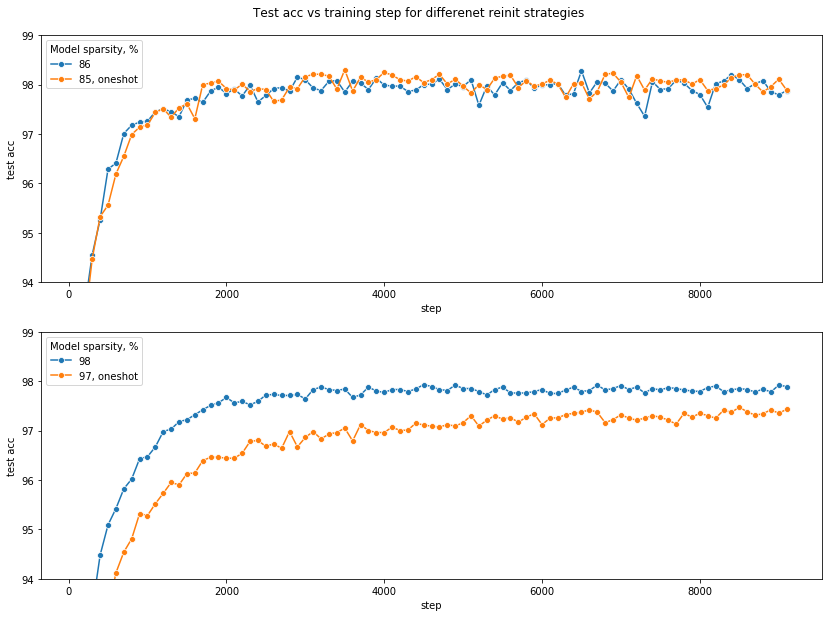

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

steps1 = (np.arange(len(results[0]['test_accs']) ) + 1) * 100

sns.lineplot(x=steps, y=results[9]['test_accs'], marker='o',
             label=labels[9], ax=axes[0])

sns.lineplot(x=steps, y=one_shot_86[1]['test_accs'], marker='o',
             label=f"{int(100*one_shot_86[1]['avg_sparsity'])}, oneshot", ax=axes[0])

axes[0].legend(title='Model sparsity, %')
axes[0].set_ylim((94, 99))
axes[0].set_ylabel('test acc')
axes[0].set_xlabel('step')

sns.lineplot(x=steps, y=results[19]['test_accs'], marker='o',
             label=labels[19], ax=axes[1])

sns.lineplot(x=steps, y=one_shot_98[1]['test_accs'], marker='o',
             label=f"{int(100*one_shot_98[1]['avg_sparsity'])}, oneshot", ax=axes[1])

axes[1].legend(title='Model sparsity, %', loc='upper left')
axes[1].set_ylabel('test acc')
axes[1].set_ylim((94, 99))
axes[1].set_xlabel('step')

plt.suptitle('Test acc vs training step for differenet reinit strategies', y=0.92);

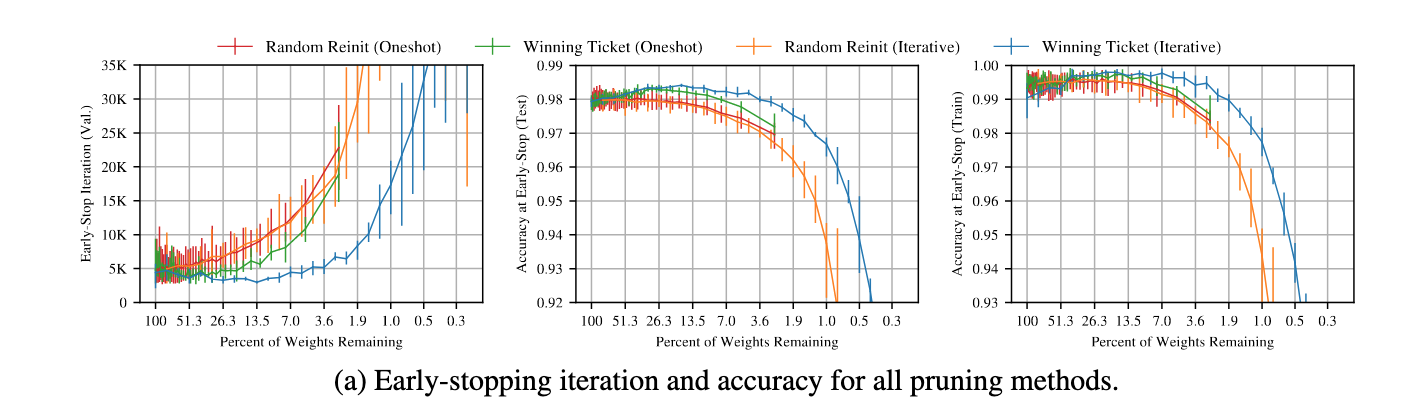

In [ ]:
early_stops = np.array([np.argmin(results[i]['val_losses']) for i in range(len(results))])
avg_saprsities = np.array([results[i]['avg_sparsity'] for i in range(len(results))])
test_acc_at_early = np.array([results[i]['test_accs'][early_stops[i]] for i in range(len(results))])

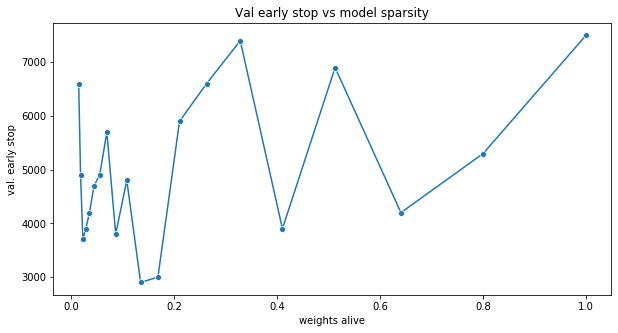

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=1-avg_saprsities, y=100*(early_stops + 1), marker='o').set(xlabel='weights alive',
                                                                          ylabel='val. early stop',
                                                                          title='Val early stop vs model sparsity');

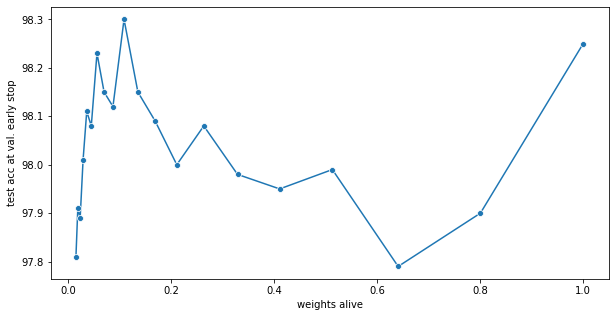

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=1-avg_saprsities, y=test_acc_at_early, marker='o').set(xlabel='weights alive',
                                                                          ylabel='test acc at val. early stop');